In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from src.data import load_data
from src.plotting import  plot_numerical_distributions, plot_monthly_avg, plot_hourly_variation

# Data Loading and Preprocessing
1. Load the cleaned data and extract time features

In [3]:
X, y = load_data()  # Load the dataset into features (X) and target variable (y)

# Convert the 'Date' column to datetime format
X['Date'] = pd.to_datetime(X['Date'], format='%d/%m/%Y', dayfirst=True)

month_mapping = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
    7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'
}

weekday_mapping = {
    0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday',
    4: 'Friday', 5: 'Saturday', 6: 'Sunday'
}

# Extract the month from the 'Date' column
X['month_n'] = X['Date'].dt.month
X['Month']=X['month_n'].map(month_mapping)


# Extract the day of the week from the 'Date' column (0=Monday, 6=Sunday)
X['dayofweek_n'] = X['Date'].dt.dayofweek

# Classify days as 'Weekend' or 'Weekday' based on the day of the week
X['Week Status'] = X['dayofweek_n'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

X['Day of Week']=X['dayofweek_n'].map(weekday_mapping)


# Create a new DataFrame 'df' from 'X'
df = X.copy()  

# Add the target variable 'Rented Bike Count' to the DataFrame
df['Rented Bike Count'] = y


Metadata:
{'uci_id': 560, 'name': 'Seoul Bike Sharing Demand', 'repository_url': 'https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand', 'data_url': 'https://archive.ics.uci.edu/static/public/560/data.csv', 'abstract': 'The dataset contains count of public bicycles rented per hour in the Seoul Bike Sharing System, with corresponding weather data and holiday information', 'area': 'Business', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 8760, 'num_features': 13, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['Functioning Day'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2020, 'last_updated': 'Mon Feb 05 2024', 'dataset_doi': '10.24432/C5F62R', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': 'Currently Rental bikes are introduced in many urban cities for the enhancement of mobility comfort. It is important to make the rental bike avail

2. Overview

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   8760 non-null   datetime64[ns]
 1   Hour                   8760 non-null   int64         
 2   Temperature            8760 non-null   float64       
 3   Humidity               8760 non-null   int64         
 4   Wind speed             8760 non-null   float64       
 5   Visibility             8760 non-null   int64         
 6   Dew point temperature  8760 non-null   float64       
 7   Solar Radiation        8760 non-null   float64       
 8   Rainfall               8760 non-null   float64       
 9   Snowfall               8760 non-null   float64       
 10  Seasons                8760 non-null   object        
 11  Holiday                8760 non-null   object        
 12  Functioning Day        8760 non-null   object        
 13  mon

In [5]:
missing_values = df.isnull().sum()
print("\nMissing Values:")
print(missing_values)


Missing Values:
Date                     0
Hour                     0
Temperature              0
Humidity                 0
Wind speed               0
Visibility               0
Dew point temperature    0
Solar Radiation          0
Rainfall                 0
Snowfall                 0
Seasons                  0
Holiday                  0
Functioning Day          0
month_n                  0
Month                    0
dayofweek_n              0
Week Status              0
Day of Week              0
Rented Bike Count        0
dtype: int64


In [6]:
unique_values = df.nunique()
print("\nUnique Values per Column:")
print(unique_values)


Unique Values per Column:
Date                      365
Hour                       24
Temperature               546
Humidity                   90
Wind speed                 65
Visibility               1789
Dew point temperature     556
Solar Radiation           345
Rainfall                   61
Snowfall                   51
Seasons                     4
Holiday                     2
Functioning Day             2
month_n                    12
Month                      12
dayofweek_n                 7
Week Status                 2
Day of Week                 7
Rented Bike Count        2166
dtype: int64


3. Clean the data

In [7]:
# Group by Date and count unique values for Holiday and Functioning Day
unique_counts = X.groupby('Date')[['Holiday', 'Functioning Day']].nunique()

# Filter dates where there are more than 1 unique value in either column
inconsistent_dates = unique_counts[(unique_counts['Holiday'] > 1) | (unique_counts['Functioning Day'] > 1)]

print("Inconsistent Dates:")
print(inconsistent_dates)

# Drop rows with inconsistent dates
df = df[~X['Date'].isin(inconsistent_dates.index)]

Inconsistent Dates:
            Holiday  Functioning Day
Date                                
2018-10-06        1                2


In [8]:
# Check whether not a Functioning Day means Rented Bike Count is zero
condition = (df['Functioning Day'] == 'No') & (df['Rented Bike Count'] != 0)
df_filtered = df[condition]
print(df_filtered)

# Update the original DataFrame to only include rows where 'Functioning Day' is 'Yes'
df = df[df['Functioning Day'] == 'Yes']



Empty DataFrame
Columns: [Date, Hour, Temperature, Humidity, Wind speed, Visibility, Dew point temperature, Solar Radiation, Rainfall, Snowfall, Seasons, Holiday, Functioning Day, month_n, Month, dayofweek_n, Week Status, Day of Week, Rented Bike Count]
Index: []


# Descriptive Statistics

In [9]:
print("DataFrame Information:")
print(df.info())

DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
Index: 8448 entries, 0 to 8759
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   8448 non-null   datetime64[ns]
 1   Hour                   8448 non-null   int64         
 2   Temperature            8448 non-null   float64       
 3   Humidity               8448 non-null   int64         
 4   Wind speed             8448 non-null   float64       
 5   Visibility             8448 non-null   int64         
 6   Dew point temperature  8448 non-null   float64       
 7   Solar Radiation        8448 non-null   float64       
 8   Rainfall               8448 non-null   float64       
 9   Snowfall               8448 non-null   float64       
 10  Seasons                8448 non-null   object        
 11  Holiday                8448 non-null   object        
 12  Functioning Day        8448 non-null   objec

1. Time Varibles

In [10]:
time_features = ['Holiday','Week Status','Seasons']
time_stats = df[time_features].describe()

print("\nCategorical Columns Descriptive Statistics:")
print(time_stats)


Categorical Columns Descriptive Statistics:
           Holiday Week Status Seasons
count         8448        8448    8448
unique           2           2       4
top     No Holiday     Weekday  Summer
freq          8040        6024    2208


d:\24fall\DS_Project\venv\lib\site-packages\src\plotting\_exploratory_plotting.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_avg, x='Month', y='Rented Bike Count', palette='viridis')


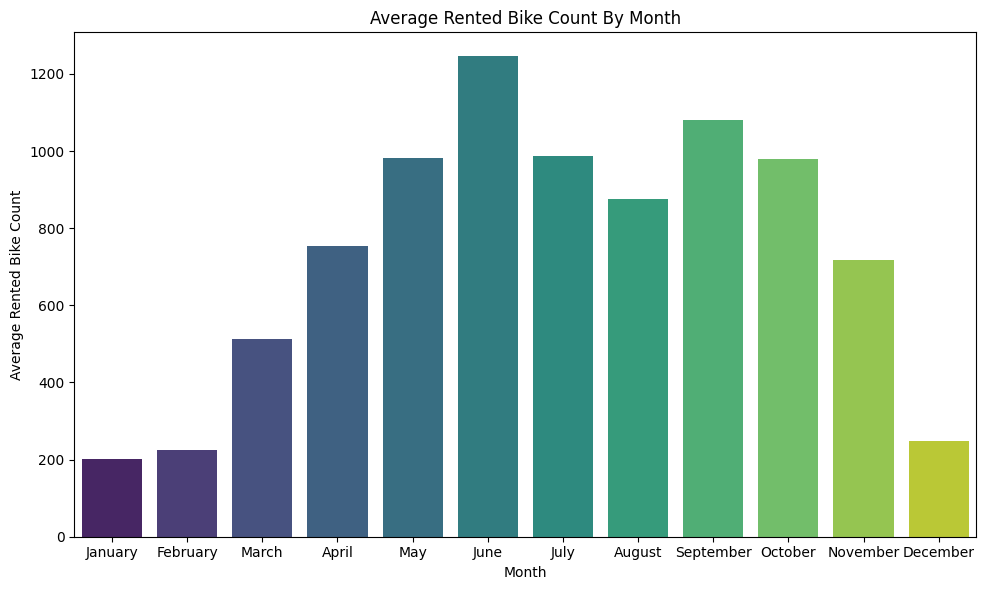

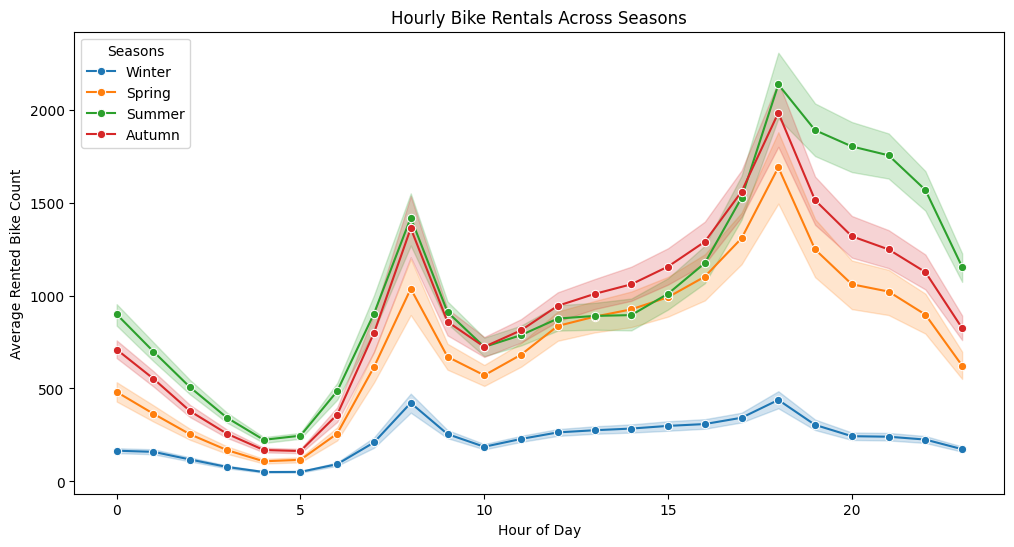

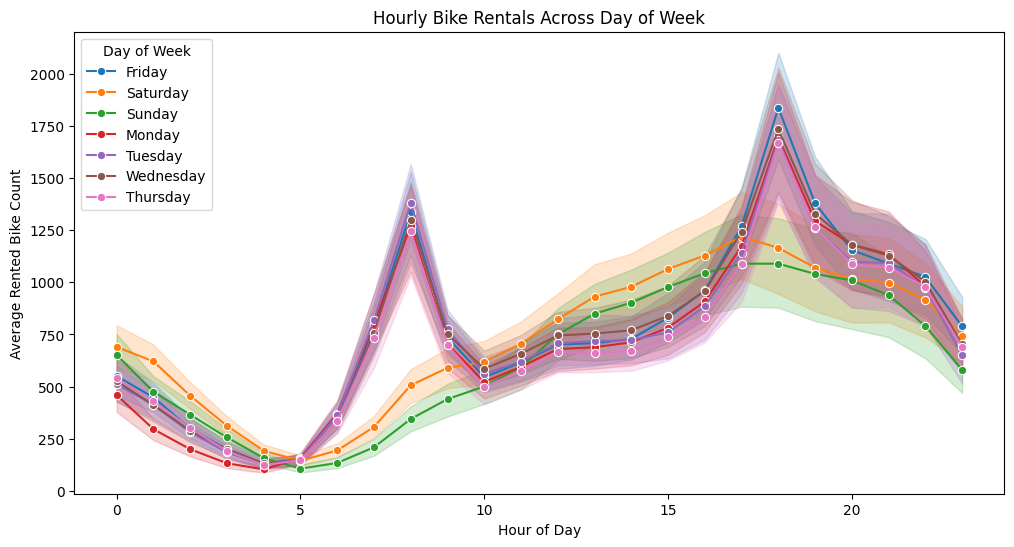

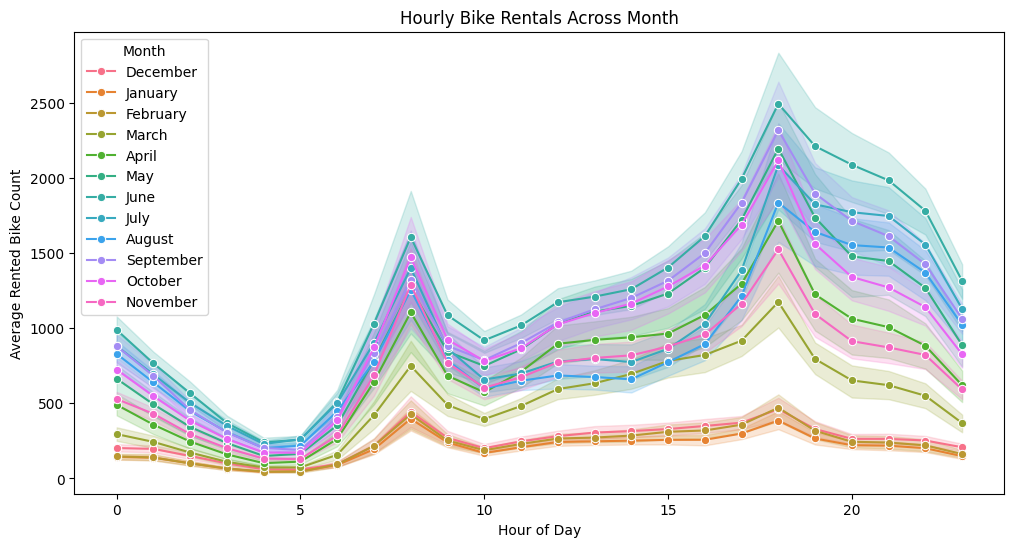

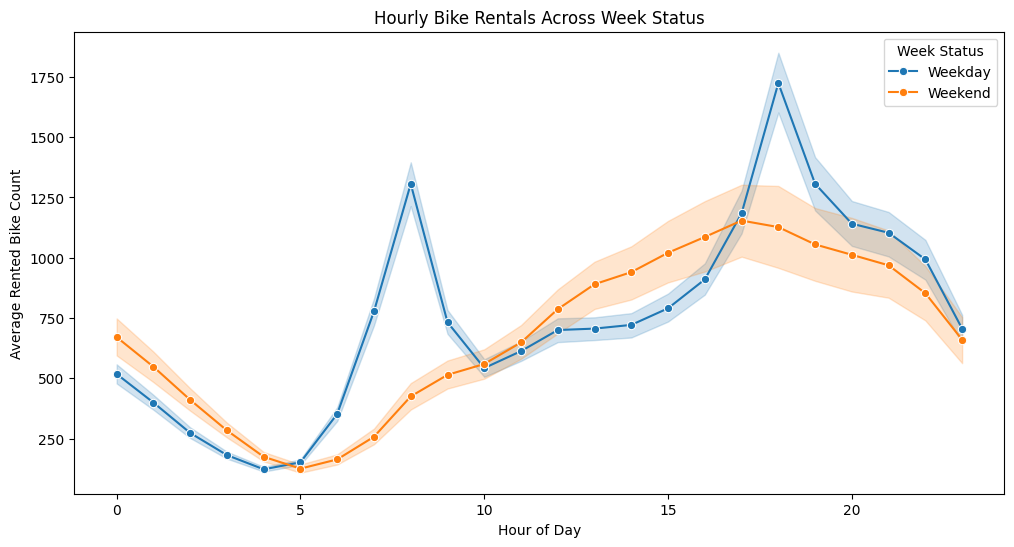

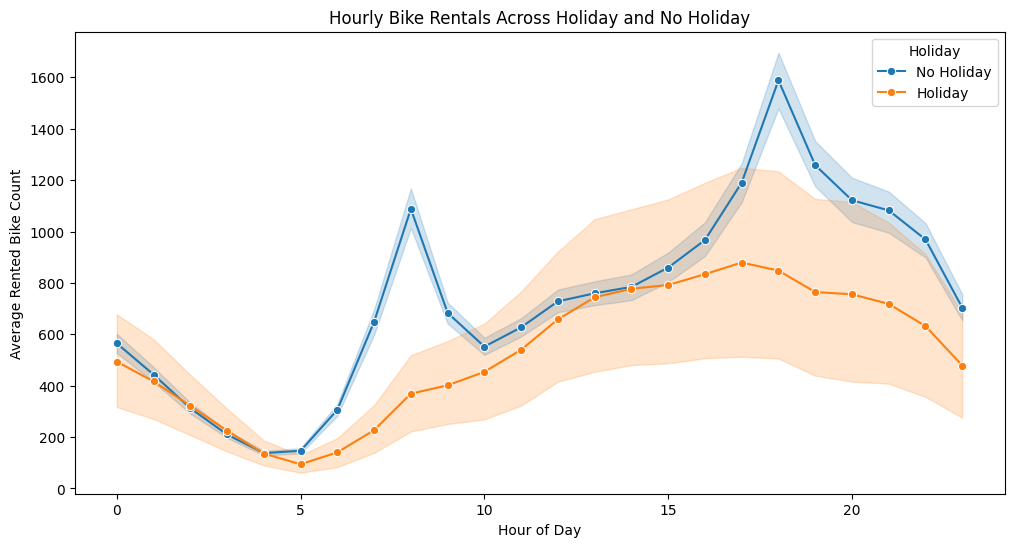

In [11]:
plot_monthly_avg(df)
plot_hourly_variation(df,"Seasons")
plot_hourly_variation(df,"Day of Week")
plot_hourly_variation(df,"Month")
plot_hourly_variation(df,"Week Status")
plot_hourly_variation(df,"Holiday")

2. Numeric Variables

In [12]:
numerical_stats = df.describe()
print("\nNumerical Columns Descriptive Statistics:")
print(numerical_stats) 


Numerical Columns Descriptive Statistics:
                                Date         Hour  Temperature     Humidity  \
count                           8448  8448.000000  8448.000000  8448.000000   
mean   2018-05-28 02:55:54.545454592    11.500000    12.759399    58.100734   
min              2017-12-01 00:00:00     0.000000   -17.800000     0.000000   
25%              2018-02-26 18:00:00     5.750000     3.000000    42.000000   
50%              2018-05-27 12:00:00    11.500000    13.400000    57.000000   
75%              2018-08-23 06:00:00    17.250000    22.700000    74.000000   
max              2018-11-30 00:00:00    23.000000    39.400000    98.000000   
std                              NaN     6.922596    12.113526    20.471167   

        Wind speed   Visibility  Dew point temperature  Solar Radiation  \
count  8448.000000  8448.000000            8448.000000      8448.000000   
mean      1.725237  1433.532079               3.922668         0.568198   
min       0.000000  

Correlation Matrix between Weather Features and Rented Bike Count

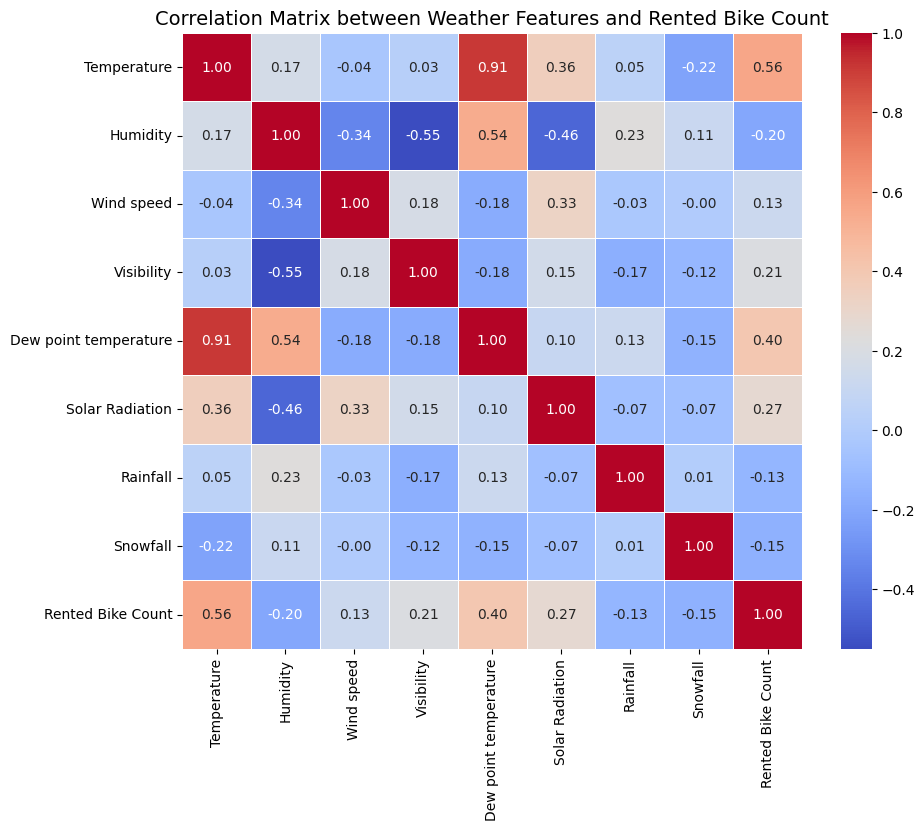

In [13]:
# Selecting variables of interest
weather_features = ['Temperature', 'Humidity', 'Wind speed', 'Visibility',
                         'Dew point temperature', 'Solar Radiation', 'Rainfall', 'Snowfall',
                         'Rented Bike Count']

# Computing correlation matrix
correlation_matrix = df[weather_features].corr()

# Visualizing correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix between Weather Features and Rented Bike Count", fontsize=14)
plt.show()

Distributions of weather factors and rented bike counts in Seoul

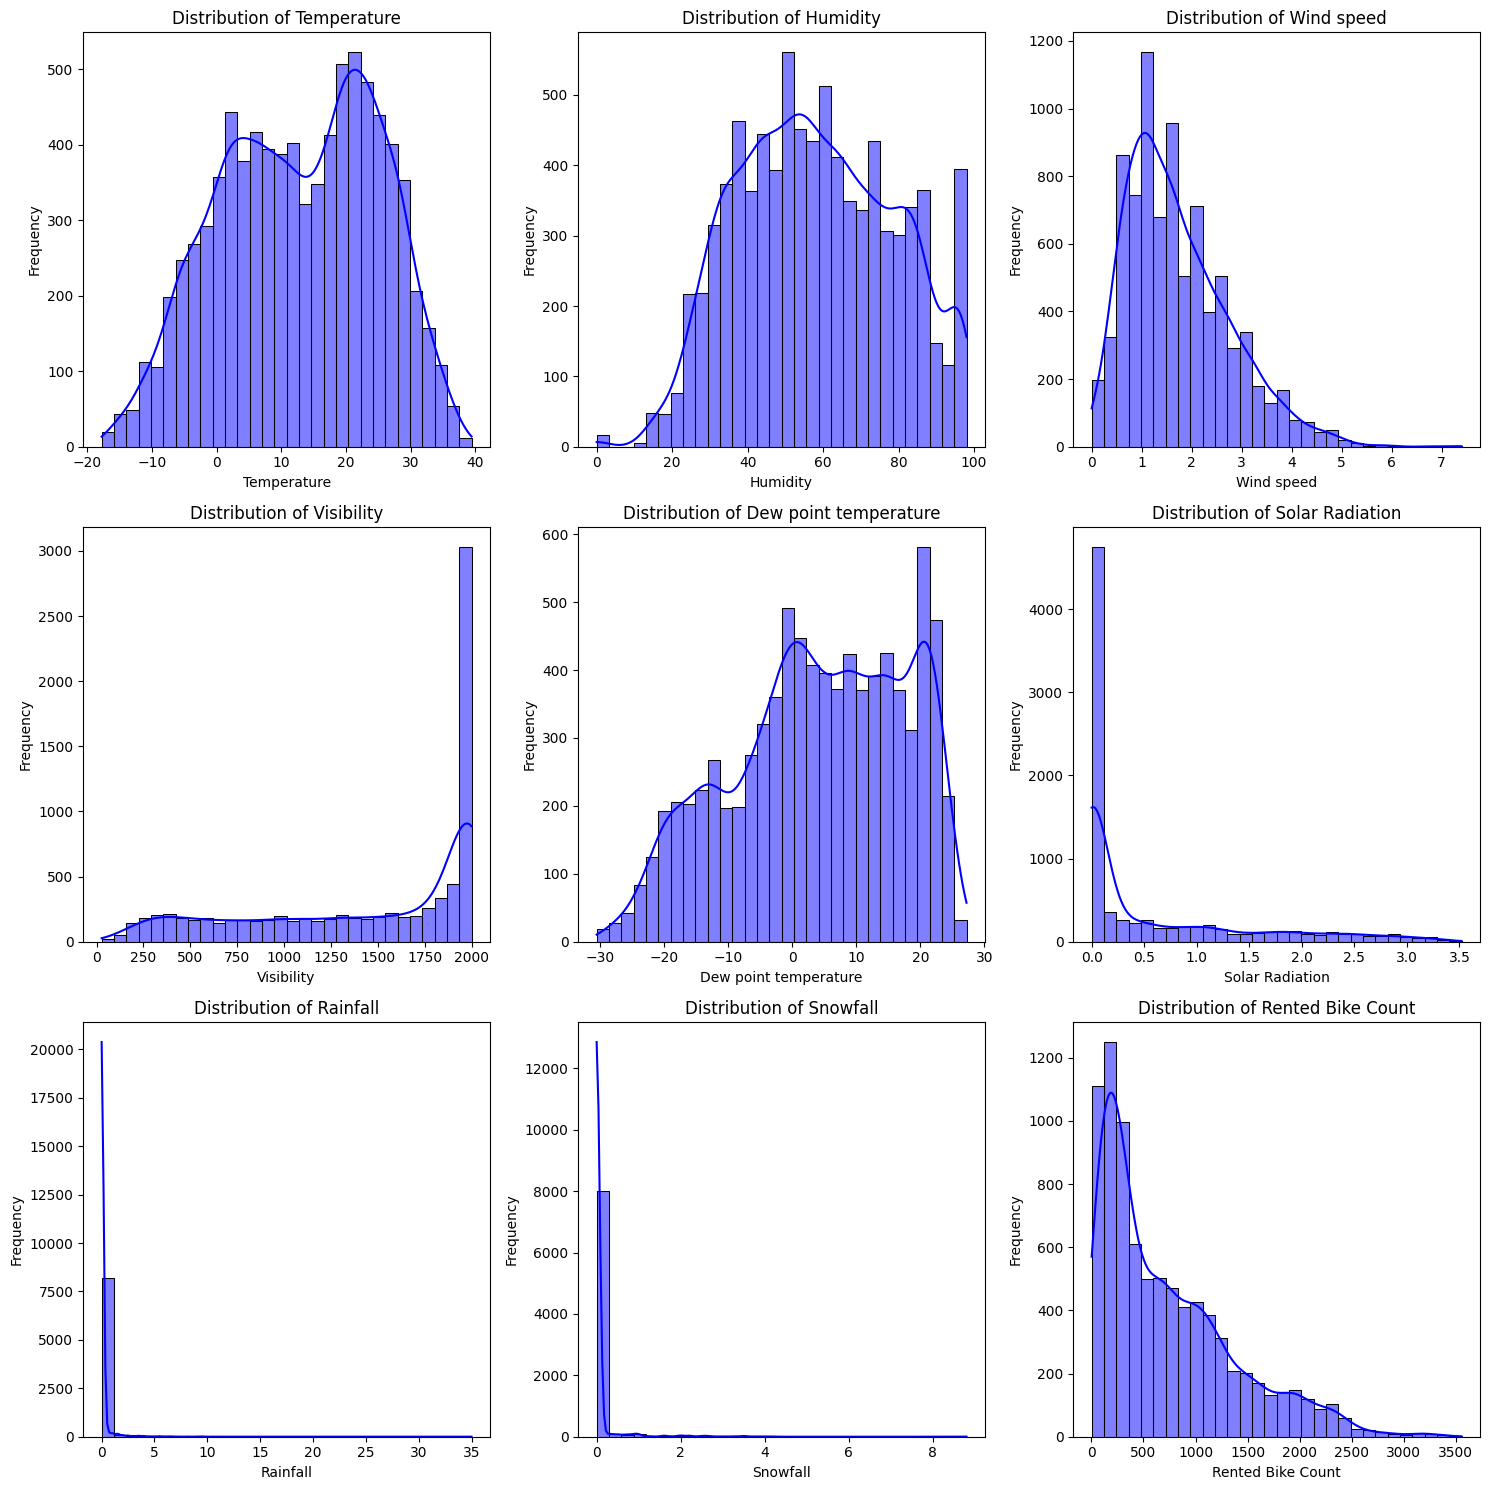

In [14]:

weather_features = ['Temperature', 'Humidity', 'Wind speed', 'Visibility', 
                      'Dew point temperature', 'Solar Radiation','Rainfall','Snowfall','Rented Bike Count']
plot_numerical_distributions(df,weather_features)


# Data Processing and Saving

In [15]:
df['Log_Windspeed'] = np.log1p(df['Wind speed'])
df['hour_n'] = df['Hour']
df['Hour'] = df['Hour'].astype(str)

In [16]:
current_dir = Path().resolve()
data_folder = current_dir.parent / "src" / "data"
data_folder.mkdir(parents=True, exist_ok=True)
output_filepath = data_folder / "cleaned_dataset.parquet"

rename_dict = {
    'Date': 'date',
    'Hour': 'hour',
    'Month': 'month',
    'Day of Week': 'day_of_week',
    'Week Status': 'week_status',
    'Holiday': 'holiday',
    'Seasons': 'season',
    'Temperature': 'temp',
    'Humidity': 'hum',
    'Log_Windspeed': 'log_wspd',
    'Visibility': 'visib',
    'Dew point temperature': 'dew_temp',
    'Solar Radiation': 'sol_rad',
    'Rainfall': 'rain',
    'Snowfall': 'snow',
    'Rented Bike Count': 'bike_cnt'
}
column_name=list(rename_dict.values())+['month_n','dayofweek_n','hour_n']
# Rename the columns
df.rename(columns=rename_dict, inplace=True)

df[column_name].to_parquet(output_filepath, index=False)

print(f"Data saved in: {output_filepath}")




Data saved in: D:\24fall\DS_Project\src\data\cleaned_dataset.parquet
